## Time Dependent Solution to Triple Well Potential

----

In this project, we're interested in the time evolution of the solutions to the
triple well potential system. In order to do this, we must first find time independent
solutions. A **stationary state** is a solution to the Time Independent Shroedinger Equation:

$\hat{H}\phi_{i} = E\phi_{i}$

If we plug this into the fully time-dependent Schroedinger equation (for time independent Hamiltonian), 

$i\hbar \frac{\partial}{\partial t} \Psi(t) = E \Psi(t)$

After some rearranging, 

$\frac{\partial}{\partial t} \Psi(t) = \frac{E}{i\hbar} \Psi(t)$

It's *trivial to show* that the solutions to this are

$\Psi(t) = e^{-iEt/\hbar} \Psi(t=0)$

Now, imagine we had some arbitrary initial state $\Psi(0)$ that was **not** a stationary
state. If we could represent this as a linear combination of stationary states, i.e.

$\Psi(0) = \sum_i c_i \phi_i(0)$

Then, the time evolution of this state is just the combination of the time evolving pieces
in its linear combination

$\Psi(t) = \sum_i c_i \phi_i(t) e^{-iEt/\hbar}$

Due to the fact that eigenfunctions of Hermitian operators from a **complete, orthogonal set**, 
we know that we can do the above transformation for **any** function spanning the same
domain as our eigenfunctions. 

So, in order to find the time evolution of an arbitrary state, we must:

    1) Find the Stationary States of the potential
    2) Determine the linear combination of stationary states that makes up the initial state
    3) Time evolve that according to the equation above
    



We begin by importing the necessary functions, and creating a triple well. 
For more information on the triple well, see its tutorial section.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from transit_chem.oneD import TripleWellPotential

triple_well = TripleWellPotential.from_params(
    well1_depth=0.8,
    well1_halfwidth=1.0,
    bridge_length=8.0,
    bridge_depth=0.5,
    well3_halfwidth=1.0,
    well3_depth=0.5,
)

fig = plt.figure()
x = np.linspace(-10, 15, 1000)
XLIM = (-5, 15)
YLIM = (-1, 2)
plt.plot(x, triple_well(x), "k")
plt.xlim(*XLIM)
plt.ylim(*YLIM)
plt.show()

<Figure size 640x480 with 1 Axes>

Here is our potential, now all we have to do is solve the time independent shroedinger 
equation for it!

$\left[ \frac{-\hbar^2}{2m}\nabla^2 + V(\mathbf{r}) \right] \psi(\mathbf{r})= E\psi(\mathbf{r})$

In computational chemistry, it is standard practice to do every calculation in **atomic units**. 
In this unit system, $\hbar = m_e = 1$

The equation simplifies to 

$\left[ \frac{-1}{2}\nabla^2 + V(\mathbf{r}) \right] \psi(\mathbf{r}) = E\psi(\mathbf{r})$

And we're only dealing with one dimension right now, so 

$\left[ \frac{-1}{2}\frac{\partial^2}{\partial x^2} + V(x) \right] \psi(x) = E\psi(x)$

We have a bit of a problem. V(x) in the triple well is not simple,
and there's no analytic solution to this problem like there is in the 
particle in a box. Let's assume that the solution to this problem can 
be represented as a linear combination of functions that we know, 

$\psi(x) = \sum_i c_i \phi_i(x)$

Where we call $\phi_i(x)$ a **basis function**. The collection of all basis functions is the **basis set**

While in theory any complete basis set is equally capable of representing our states, 
Choosing a basis set is one of the most important considerations in practice. We can't actually
ever use a complete basis set (due to computational limits), so it's important to choose one that is closer to the actual eigenbasis. 
Since our triple well potential is three harmonic wells, it seems reasonable to pick a set of harmonic oscillator
basis functions, with some cenetered in each well. 


Additionally, we want to make sure we can represent our states accurately, but we don't care about all states equally.
The most important states to get right are the low energy states. So as long as we can choose a basis
that gets the most important low energy states right, we're golden. A common means of doing this is to choose
an energy cutoff in for the basis set functions. Since we're dealing with Harmonic Oscillators, this means
we choose basis functions for which

$(n + 1/2) \hbar \omega \leq E_{\mathrm{cutoff}}$

We've included a convenience function to do this in the library, here's what it looks like:

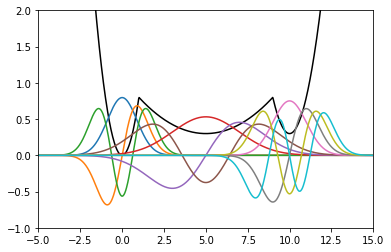

In [2]:
from transit_chem.basis import HarmonicOscillator, harmonic_basis_from_parabola

cutoff_energy = 4
basis = (
    harmonic_basis_from_parabola(triple_well.well1, cutoff_energy=cutoff_energy)
    + harmonic_basis_from_parabola(triple_well.well2, cutoff_energy=cutoff_energy)[:3]  # Only keep first 3 for demo purposes
    + harmonic_basis_from_parabola(triple_well.well3, cutoff_energy=cutoff_energy)
)

fig = plt.figure()
plt.plot(x, triple_well(x), "k")
for b in basis:
    plt.plot(x, b(x))
plt.xlim(*XLIM)
plt.ylim(*YLIM)  
plt.show()

You can see how we have good coverage of the potential well from our basis. Now we need to use this basis
and find our stationary states (eigenfunctions of $\mathbf{H}$). We've introduced a bit of a problem though. 
Harmonic oscillator wave functions form an **orthonormal** set. However, we've created basis functions
on different wells, and their overlap is nonzero. Our basis set is **non-orthogonal**. To account for this, 
we don't solve the ordinary eigenvalue problem

$\mathbf{H} \mathbf{C} = \mathbf{E} \mathbf{C}$

but we must account for the non-orthogonal basis. Now we must solve the following **generalized eigenvalue problem**

$\mathbf{H} \mathbf{C} = \mathbf{E} \mathbf{S} \mathbf{C}$

where we use the common definitions of 


The **Overlap Matrix**

$\mathbf{S}_{ij} = \int_{-\infty}^{\infty} \phi_i(x)\phi_{j}^*(x)dx$

and **Hamiltonian Matrix**

$\mathbf{H}_{ij} = \int_{-\infty}^{\infty} \phi_i(x)\hat{H}\phi_{j}^*(x)dx$

Where $\phi_i(x)$ is the $i$th basis function. So in order to get our stationary states, 
we must solve the generalized eigenvalue problem for the matrices defined above. The
process of getting Matrices from operators is used all the time, so we've made it easy to 
do this operation:

In [3]:
from transit_chem import operators as op
from transit_chem.utils import pairwise_array_from_func

S = pairwise_array_from_func(basis, op.overlap, symmetric=True)
H = pairwise_array_from_func(basis, op.Hamiltonian(triple_well), symmetric=True)

np.set_printoptions(precision=3, suppress=True)
print("S:\n", S, "\nH:\n", H)

S:
 [[ 1.     0.     0.     0.063 -0.187  0.361  0.    -0.     0.    -0.   ]
 [ 0.     1.     0.     0.083 -0.199  0.277  0.    -0.     0.    -0.   ]
 [ 0.     0.     1.     0.107 -0.229  0.28   0.    -0.     0.    -0.   ]
 [ 0.063  0.083  0.107  1.    -0.     0.     0.073 -0.104  0.135 -0.161]
 [-0.187 -0.199 -0.229 -0.     1.    -0.     0.208 -0.235  0.264 -0.269]
 [ 0.361  0.277  0.28   0.    -0.     1.     0.384 -0.308  0.283 -0.21 ]
 [ 0.     0.     0.     0.073  0.208  0.384  1.     0.     0.     0.   ]
 [-0.    -0.    -0.    -0.104 -0.235 -0.308  0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.135  0.264  0.283  0.     0.     1.     0.   ]
 [-0.    -0.    -0.    -0.161 -0.269 -0.21   0.     0.     0.     1.   ]] 
H:
 [[ 0.599 -0.079 -0.117  0.    -0.034  0.127 -0.     0.    -0.     0.   ]
 [-0.079  1.699 -0.308  0.029 -0.119  0.236 -0.     0.    -0.     0.   ]
 [-0.117 -0.308  2.645  0.055 -0.189  0.34  -0.     0.    -0.     0.   ]
 [ 0.     0.029  0.055  0.423  0.001 -0.0

And a quick sanity check on the values: the $\mathbf{S}$ matrix has ones on the diagonal, so our basis is normalized. The overlap within each well
is also orthogonal, as expected (look at the submatrices for each well). But there is some non zero overlap between basis functions
of different wells, as expected. The elements of $\mathbf{H}$ are also reasonable. The diagonal elements are close, but not equal to the 
harmonic oscillator energy levels. 


Since we're gonna want to get the eigenbasis a lot, we've included some convenience utilities to generate the eigenstates 
from a basis and the $\mathbf{H}$ and $\mathbf{S}$ matrices. Let's generate the eigen basis, and look at some of the low
lying energy states:

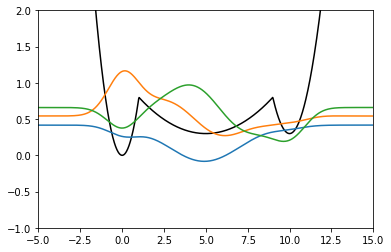

In [4]:
from transit_chem.basis import EigenBasis

eig_basis = EigenBasis.from_basis(basis, H, S)

fig = plt.figure()
plt.plot(x, triple_well(x), "k")
for state, energy in zip(eig_basis.states[:3], eig_basis.energies[:3]):
    plt.plot(x, state(x) + energy)

plt.xlim(*XLIM)
plt.ylim(*YLIM)
plt.show()

Above is the first few stationary states for our potential, offset by their energy
for visual clarity. These states look intuitively reasonable. The Lowest energy state
has no nodes, and is pretty delocalized. The next energy state has 1 node, and the third
has 2 nodes. This is in line with what we'd expect. Let's do a sanity check to make
sure that our eigenbasis is orthonormal, as it should be:

In [5]:
pairwise_array_from_func(eig_basis.states, op.overlap, symmetric=True)

array([[ 1.,  0.,  0., -0.,  0., -0., -0., -0.,  0.,  0.],
       [ 0.,  1., -0., -0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0., -0.,  1.,  0., -0., -0.,  0., -0., -0.,  0.],
       [-0., -0.,  0.,  1., -0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0., -0., -0.,  1.,  0., -0.,  0.,  0., -0.],
       [-0.,  0., -0.,  0.,  0.,  1., -0., -0.,  0., -0.],
       [-0.,  0.,  0.,  0., -0., -0.,  1., -0., -0.,  0.],
       [-0.,  0., -0.,  0.,  0., -0., -0.,  1.,  0., -0.],
       [ 0., -0., -0., -0.,  0.,  0., -0.,  0.,  1., -0.],
       [ 0., -0.,  0., -0., -0., -0.,  0., -0., -0.,  1.]])

Boom! The overlap matrix is the identity, which means our eigenbasis is indeed orthonormal. And 
to double check that we actually do have the eigen basis, we can check that the Hamiltonian matrix
in the eigenbasis is diagonal:

In [6]:
pairwise_array_from_func(eig_basis.states, op.Hamiltonian(triple_well), symmetric=True)

array([[ 0.417,  0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,
        -0.   , -0.   ],
       [ 0.   ,  0.542,  0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ,
        -0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.66 ,  0.   , -0.   ,  0.   , -0.   , -0.   ,
         0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.821,  0.   , -0.   , -0.   ,  0.   ,
         0.   , -0.   ],
       [-0.   ,  0.   , -0.   ,  0.   ,  1.1  , -0.   ,  0.   , -0.   ,
        -0.   , -0.   ],
       [ 0.   , -0.   ,  0.   , -0.   , -0.   ,  1.641,  0.   ,  0.   ,
        -0.   ,  0.   ],
       [-0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   ,  1.903,  0.   ,
         0.   , -0.   ],
       [ 0.   , -0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  2.518,
         0.   , -0.   ],
       [-0.   , -0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   ,
         2.981, -0.   ],
       [-0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   , -0.   , -0.   ,
        -0.   ,  3.572]])

It's certainly diagonal! And we can see that the diagonal elements are exactly equal to the eigenbasis energies:

In [7]:
print(eig_basis.energies)

[0.417157344907191, 0.5422267170289595, 0.6598887597917339, 0.8214559401063642, 1.0996732067543125, 1.6405850993321849, 1.902799642096666, 2.5181625660099582, 2.9809270860776307, 3.5719909933761516]


Ok so we now have solved for the stationary states of the triple well. Now all we do is pick some initial state, 
and we can evolve it over time. To do this, we represent the initial state as a linear 
combination of stationary states, and evolve through time via 

$\Psi(t) = \sum_i c_i \phi_i(t) e^{-iEt/\hbar}$

It just so happens that we've implemented this in the libary! So all you need to do
to turn an initial state into a time-dependent one is to call our function:

In [11]:
initial_state = HarmonicOscillator(center=0.0, n=0)
time_evolving = eig_basis.time_evolving(initial_state)

To get a feel for what's going on, let's take a look at the probability density
of our state over time. 

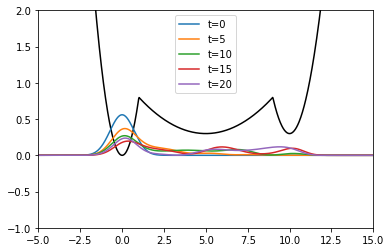

In [12]:
def density(x, t):
    wf = time_evolving(x, t)
    return np.real(wf * np.conj(wf))

fig = plt.figure()
plt.plot(x, triple_well(x), "k")
for t in range(0, 25, 5):
    plt.plot(x, density(x, t), label=f"t={t}")
    
plt.legend()
plt.xlim(*XLIM)
plt.ylim(*YLIM)
plt.show()

It's a bit hard to visualize (animation documentation PR is welcome!), but the state is initially localized towards the first well. Over time, the
density oscillates towards the middle well and even the last well. The density will oscillate forever like this. 

C:\Users\Evan\Anaconda3\envs\transit-chem\lib\site-packages\scipy\integrate\quadpack.py:450: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
C:\Users\Evan\Anaconda3\envs\transit-chem\lib\site-packages\scipy\integrate\quadpack.py:448: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
C:\Users\Evan\Anaconda3\envs\transit-chem\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


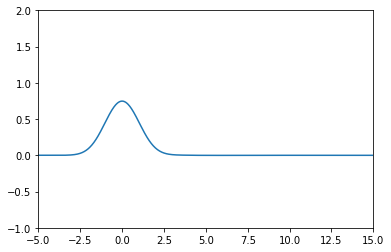

In [17]:
from functools import partial

ic = partial(time_evolving, t=0)

spar1 = op.overlap(ic, ic, upper_limit=triple_well.barrier12[0])
spar2 = op.overlap(ic, ic, lower_limit=triple_well.barrier12[0], upper_limit=triple_well.barrier23[0])
spar3 = op.overlap(ic, ic, lower_limit=triple_well.barrier23[0])

fig = plt.figure()
plt.plot(x, ic(x))
plt.xlim(*XLIM)
plt.ylim(*YLIM)
plt.show()

In [18]:
print(spar1, spar2, spar3, spar1+spar2+spar3)

0.9209510029586557 0.07899641860095381 1.4186903872835573e-07 0.9999475634286483
